# Notebook 2: Nén ảnh Grayscale bằng SVD

**Mục tiêu:** Áp dụng SVD để nén ảnh xám thực tế và đánh giá chất lượng.

**Nội dung:**
1. Load ảnh grayscale
2. Áp dụng SVD compression với k khác nhau
3. Đánh giá chất lượng (PSNR, MSE)
4. Visualize kết quả
5. Phân tích compression ratio

## 1. Setup và Import

In [2]:
# Import các module đã tạo
import sys
sys.path.append('../src')  # Thêm path đến thư mục src

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Import các modules tự viết
from image_utils import load_image, save_image, convert_to_grayscale, get_image_info
from svd_compression import compress_grayscale, get_svd_matrices, calculate_compression_ratio, calculate_cumulative_energy
from quality_metrics import calculate_mse, calculate_psnr, calculate_all_metrics, evaluate_compression_quality

# Settings
plt.rcParams['figure.figsize'] = (16, 10)
sns.set_style("whitegrid")

print("✅ Import thành công!")

✅ Import thành công!


## 2. Chuẩn bị

Trong bài thực hành này, chúng ta sẽ sử dụng ảnh thật từ thư mục `images/grayscale/`.

**Ảnh test:** `5.3.01.tiff` (Standard test image)

## 3. Load ảnh Grayscale

**Lưu ý:** Nếu bạn có ảnh thật (Lena, Cameraman...), đặt vào thư mục `../images/grayscale/` và load ở đây.

## 3. Load ảnh Grayscale

Sử dụng ảnh test chuẩn **5.3.01.tiff** từ USC-SIPI Image Database.

## 4. Phân tích SVD của ảnh

In [5]:
# Lấy SVD matrices
U, S, Vt = get_svd_matrices(original)

print(f"SVD Matrices:")
print(f"  U: {U.shape}")
print(f"  S: {S.shape}")
print(f"  Vt: {Vt.shape}")
print(f"\nTop 10 singular values: {S[:10]}")

SVD Matrices:
  U: (256, 256)
  S: (256,)
  Vt: (256, 256)

Top 10 singular values: [3.33111326e+04 7.67963170e+03 5.90582198e+02 1.15796465e+01
 1.08017412e+01 1.04001291e+01 1.00599255e+01 9.49653980e+00
 9.47522666e+00 9.13110104e+00]


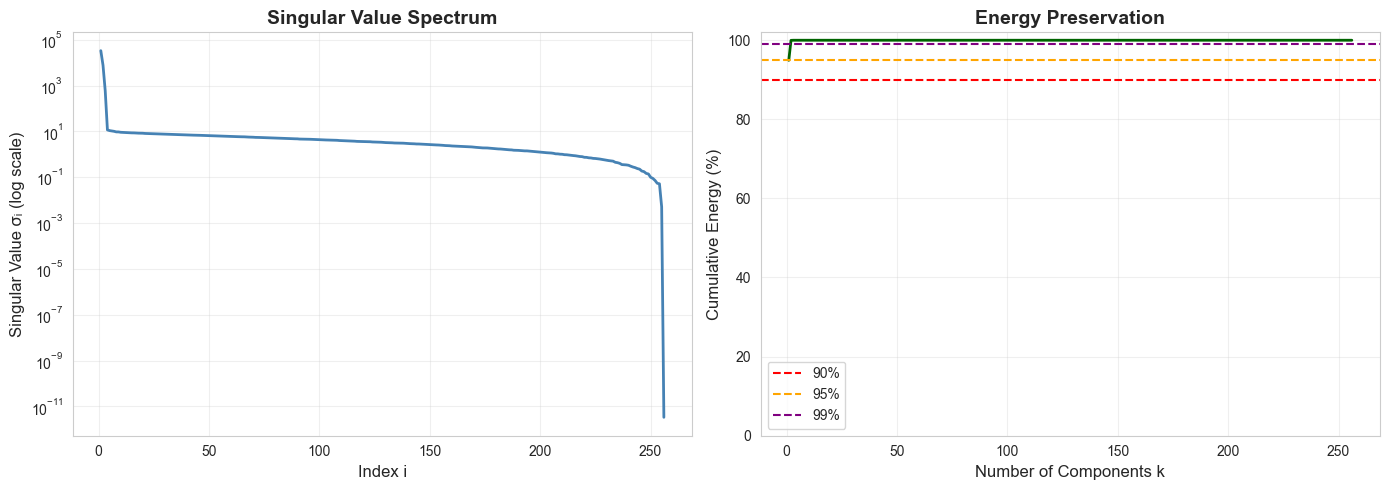


Để giữ được:
  90% năng lượng: cần k = 1
  95% năng lượng: cần k = 2
  99% năng lượng: cần k = 2


In [6]:
# Visualize Singular Value Spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Singular values (log scale)
axes[0].semilogy(range(1, len(S)+1), S, linewidth=2, color='steelblue')
axes[0].set_xlabel('Index i', fontsize=12)
axes[0].set_ylabel('Singular Value σᵢ (log scale)', fontsize=12)
axes[0].set_title('Singular Value Spectrum', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative Energy
cumulative_energy = calculate_cumulative_energy(S)
axes[1].plot(range(1, len(S)+1), cumulative_energy, linewidth=2, color='darkgreen')
axes[1].axhline(y=90, color='red', linestyle='--', linewidth=1.5, label='90%')
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=1.5, label='95%')
axes[1].axhline(y=99, color='purple', linestyle='--', linewidth=1.5, label='99%')
axes[1].set_xlabel('Number of Components k', fontsize=12)
axes[1].set_ylabel('Cumulative Energy (%)', fontsize=12)
axes[1].set_title('Energy Preservation', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 102])

plt.tight_layout()
plt.savefig('../results/visualizations/singular_value_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Tìm k cần thiết
k_90 = np.argmax(cumulative_energy >= 90) + 1
k_95 = np.argmax(cumulative_energy >= 95) + 1
k_99 = np.argmax(cumulative_energy >= 99) + 1

print(f"\nĐể giữ được:")
print(f"  90% năng lượng: cần k = {k_90}")
print(f"  95% năng lượng: cần k = {k_95}")
print(f"  99% năng lượng: cần k = {k_99}")

## 5. Nén ảnh với k khác nhau

In [7]:
# Các giá trị k để test
k_values = [5, 10, 20, 50, 100]

# Dictionary để lưu kết quả
results = {}

print("Nén ảnh với các giá trị k khác nhau...\n")

for k in k_values:
    # Nén ảnh
    compressed = compress_grayscale(original, k)
    
    # Tính metrics
    metrics = calculate_all_metrics(original, compressed, include_ssim=True)
    
    # Tính compression ratio
    comp_stats = calculate_compression_ratio(original.shape, k, is_rgb=False)
    
    # Lưu kết quả
    results[k] = {
        'compressed': compressed,
        'metrics': metrics,
        'compression_stats': comp_stats
    }
    
    # In kết quả
    print(f"k = {k:3d}:")
    print(f"  MSE:  {metrics['mse']:.2f}")
    print(f"  PSNR: {metrics['psnr']:.2f} dB - {evaluate_compression_quality(metrics['psnr'])}")
    print(f"  SSIM: {metrics['ssim']:.4f}")
    print(f"  Space saved: {comp_stats['space_saved_percent']:.1f}%")
    print()

print("✅ Hoàn thành nén!")

Nén ảnh với các giá trị k khác nhau...

k =   5:
  MSE:  0.50
  PSNR: 51.15 dB - Excellent (rất tốt, gần như không phân biệt được)
  SSIM: 0.9999
  Space saved: 96.1%

k =  10:
  MSE:  0.50
  PSNR: 51.16 dB - Excellent (rất tốt, gần như không phân biệt được)
  SSIM: 0.9999
  Space saved: 92.2%

k =  20:
  MSE:  0.50
  PSNR: 51.15 dB - Excellent (rất tốt, gần như không phân biệt được)
  SSIM: 0.9999
  Space saved: 84.3%

k =  50:
  MSE:  0.50
  PSNR: 51.14 dB - Excellent (rất tốt, gần như không phân biệt được)
  SSIM: 0.9999
  Space saved: 60.9%

k = 100:
  MSE:  0.50
  PSNR: 51.15 dB - Excellent (rất tốt, gần như không phân biệt được)
  SSIM: 0.9999
  Space saved: 21.7%

✅ Hoàn thành nén!


## 6. Visualize kết quả nén

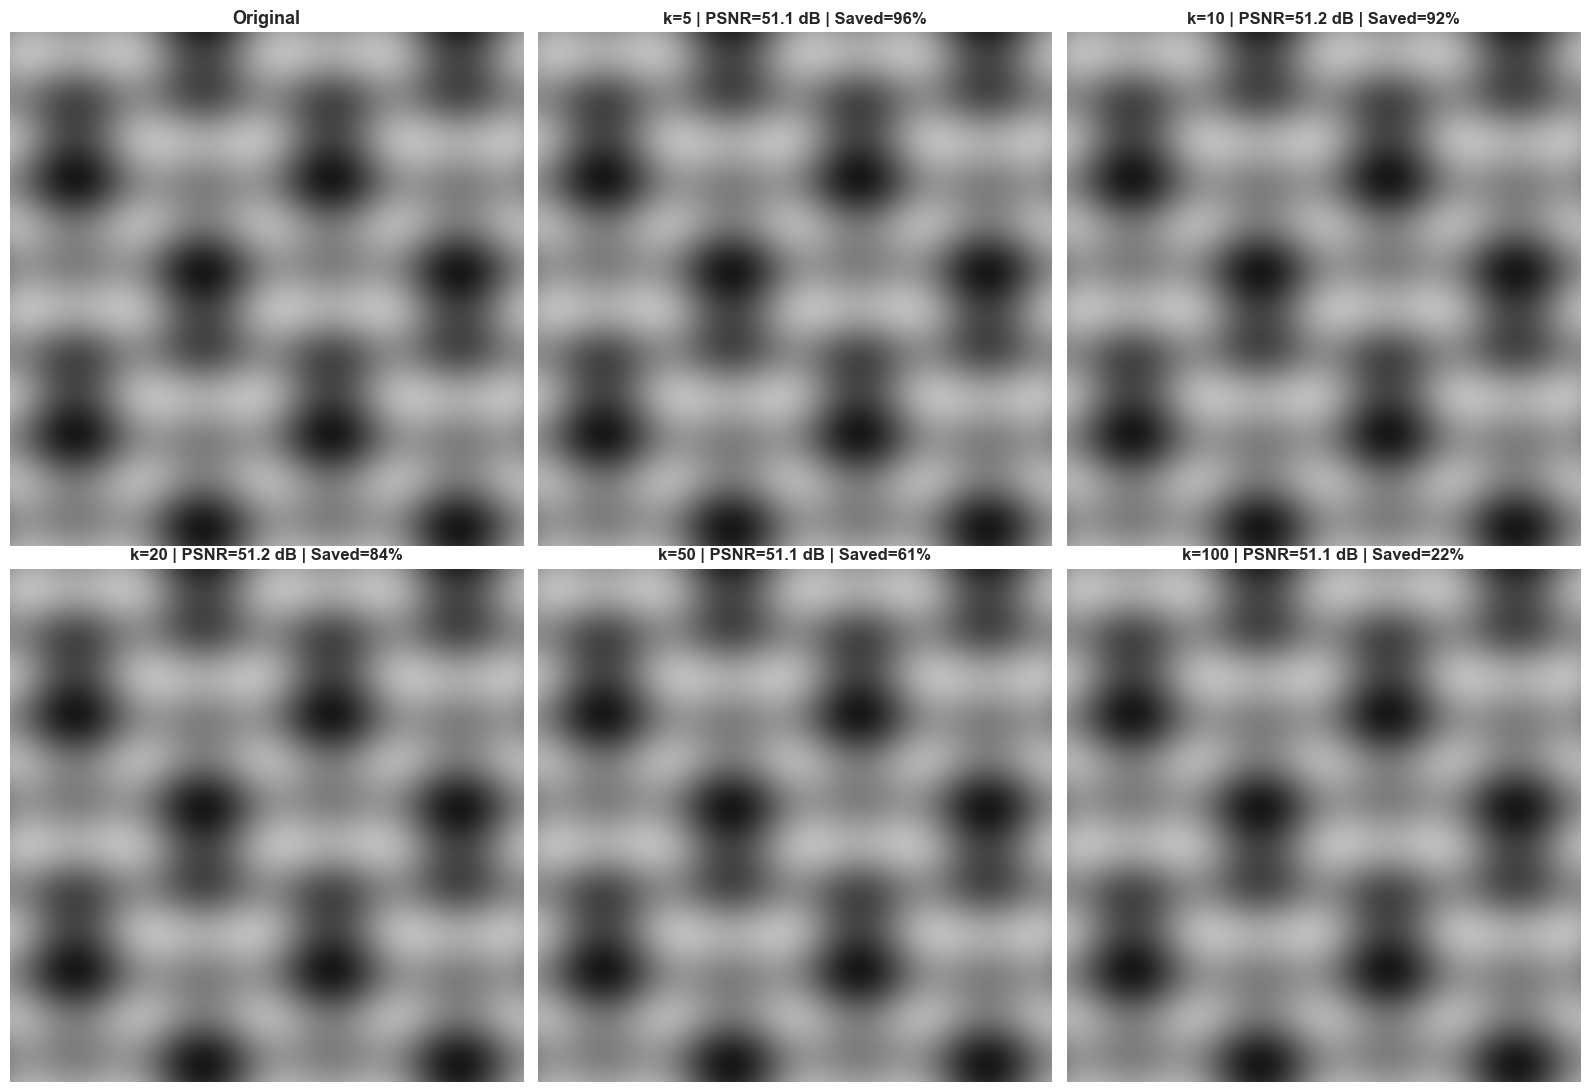

In [8]:
# So sánh visual
fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

# Original
axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Original', fontsize=13, fontweight='bold')
axes[0].axis('off')

# Compressed versions
for idx, k in enumerate(k_values, start=1):
    compressed = results[k]['compressed']
    psnr = results[k]['metrics']['psnr']
    space_saved = results[k]['compression_stats']['space_saved_percent']
    
    axes[idx].imshow(compressed, cmap='gray', vmin=0, vmax=255)
    axes[idx].set_title(f'k={k} | PSNR={psnr:.1f} dB | Saved={space_saved:.0f}%', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/visualizations/compression_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Error Maps (Bản đồ sai số)

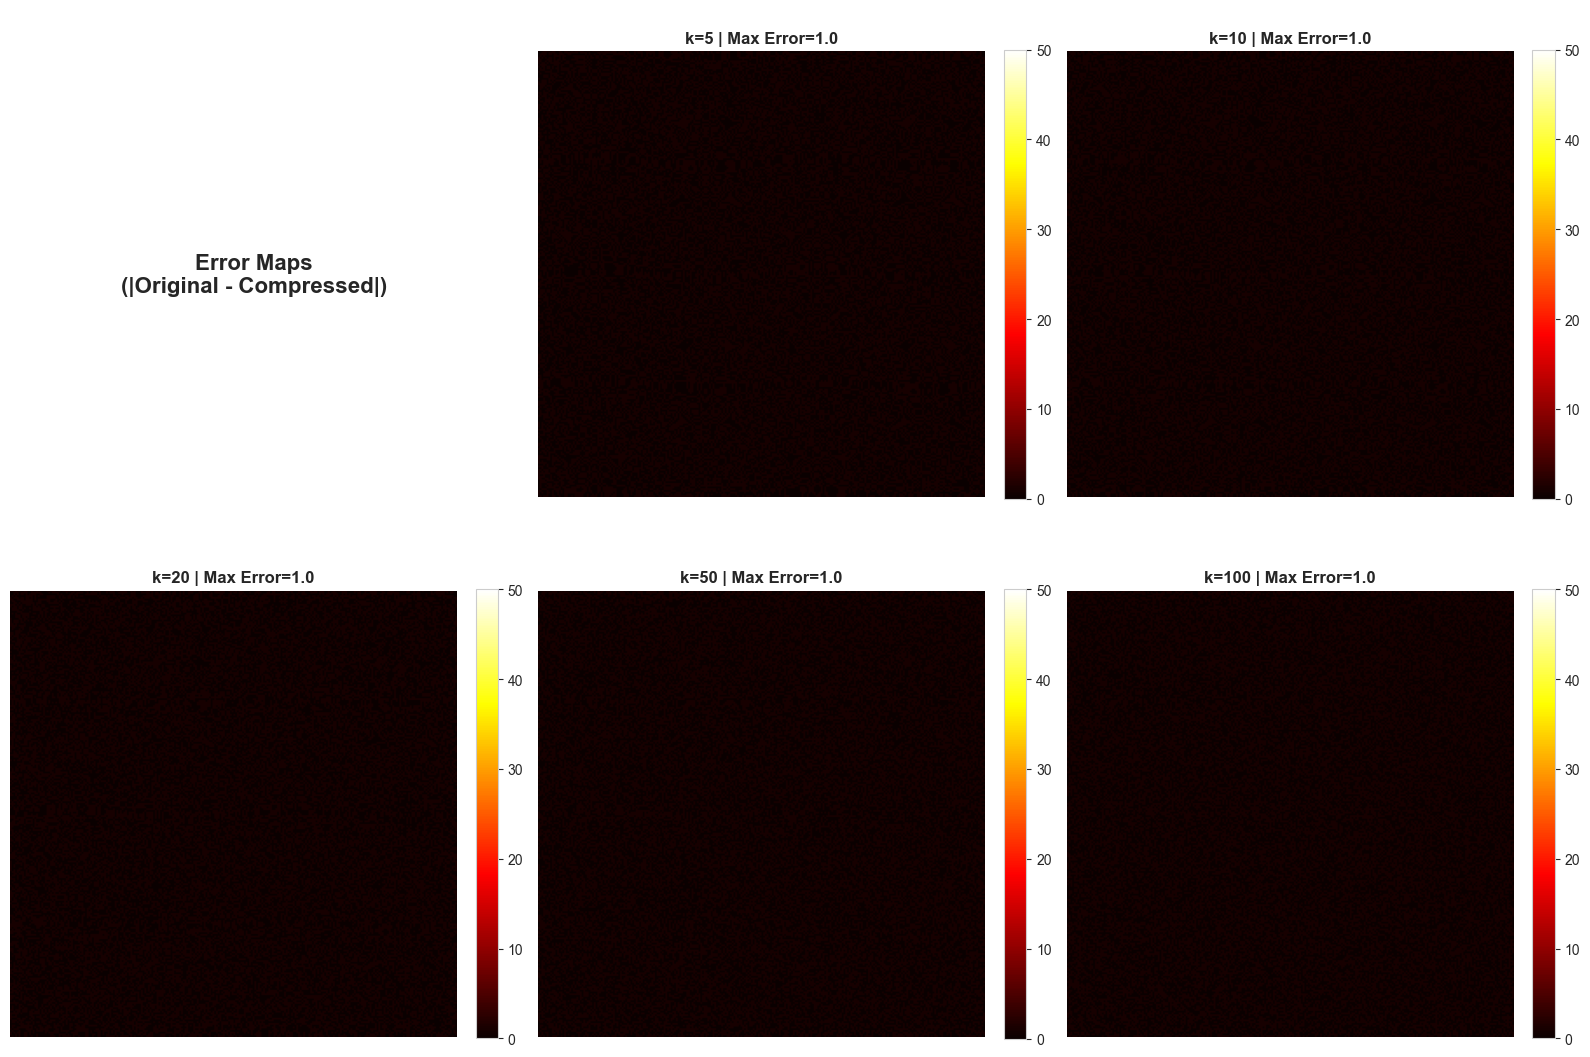

In [9]:
# Visualize error maps
fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

axes[0].text(0.5, 0.5, 'Error Maps\n(|Original - Compressed|)', 
             ha='center', va='center', fontsize=16, fontweight='bold')
axes[0].axis('off')

for idx, k in enumerate(k_values, start=1):
    compressed = results[k]['compressed']
    error_map = np.abs(original.astype(np.float64) - compressed.astype(np.float64))
    
    im = axes[idx].imshow(error_map, cmap='hot', vmin=0, vmax=50)
    axes[idx].set_title(f'k={k} | Max Error={error_map.max():.1f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('../results/visualizations/error_maps.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Quality vs k Analysis

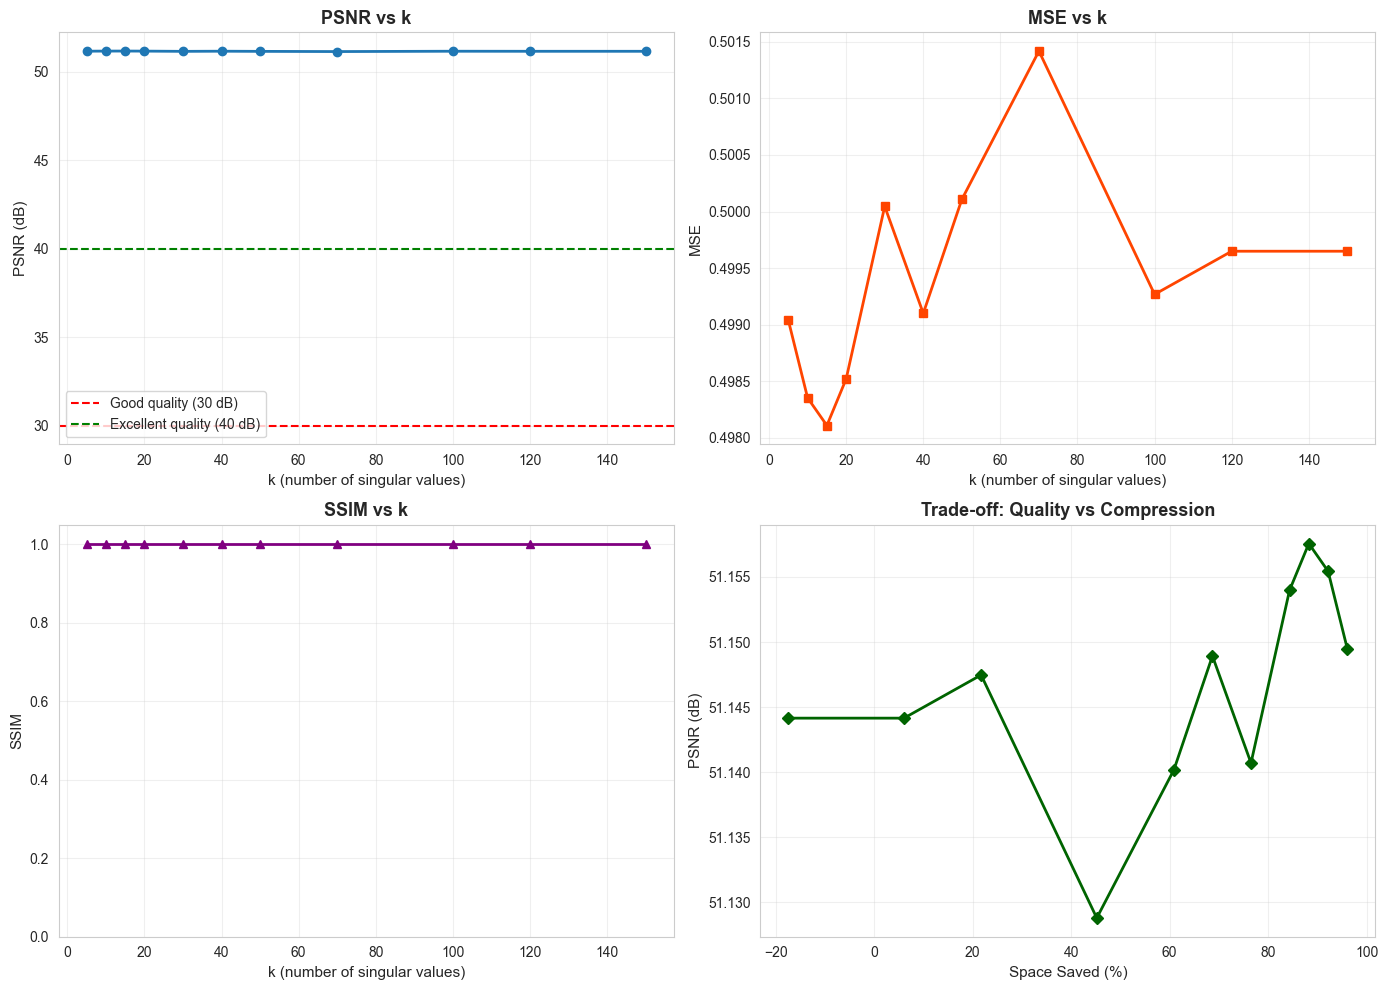

In [10]:
# Test với nhiều k hơn để vẽ đồ thị
k_range = [5, 10, 15, 20, 30, 40, 50, 70, 100, 120, 150]
psnr_values = []
mse_values = []
ssim_values = []
compression_ratios = []

for k in k_range:
    if k <= min(original.shape):
        compressed = compress_grayscale(original, k)
        metrics = calculate_all_metrics(original, compressed, include_ssim=True)
        comp_stats = calculate_compression_ratio(original.shape, k, is_rgb=False)
        
        psnr_values.append(metrics['psnr'])
        mse_values.append(metrics['mse'])
        ssim_values.append(metrics['ssim'])
        compression_ratios.append(comp_stats['space_saved_percent'])

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PSNR vs k
axes[0, 0].plot(k_range[:len(psnr_values)], psnr_values, marker='o', linewidth=2, markersize=6)
axes[0, 0].axhline(y=30, color='red', linestyle='--', label='Good quality (30 dB)')
axes[0, 0].axhline(y=40, color='green', linestyle='--', label='Excellent quality (40 dB)')
axes[0, 0].set_xlabel('k (number of singular values)', fontsize=11)
axes[0, 0].set_ylabel('PSNR (dB)', fontsize=11)
axes[0, 0].set_title('PSNR vs k', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MSE vs k
axes[0, 1].plot(k_range[:len(mse_values)], mse_values, marker='s', 
                linewidth=2, markersize=6, color='orangered')
axes[0, 1].set_xlabel('k (number of singular values)', fontsize=11)
axes[0, 1].set_ylabel('MSE', fontsize=11)
axes[0, 1].set_title('MSE vs k', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# SSIM vs k
axes[1, 0].plot(k_range[:len(ssim_values)], ssim_values, marker='^', 
                linewidth=2, markersize=6, color='purple')
axes[1, 0].set_xlabel('k (number of singular values)', fontsize=11)
axes[1, 0].set_ylabel('SSIM', fontsize=11)
axes[1, 0].set_title('SSIM vs k', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim([0, 1.05])
axes[1, 0].grid(True, alpha=0.3)

# Compression ratio vs PSNR
axes[1, 1].plot(compression_ratios, psnr_values, marker='D', 
                linewidth=2, markersize=6, color='darkgreen')
axes[1, 1].set_xlabel('Space Saved (%)', fontsize=11)
axes[1, 1].set_ylabel('PSNR (dB)', fontsize=11)
axes[1, 1].set_title('Trade-off: Quality vs Compression', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/quality_vs_k_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Tìm k tối ưu

Tìm k nhỏ nhất sao cho PSNR ≥ 30 dB (good quality)

In [12]:
# Tìm k tối ưu
target_psnr = 30  # dB

for k, psnr in zip(k_range[:len(psnr_values)], psnr_values):
    if psnr >= target_psnr:
        optimal_k = k
        optimal_psnr = psnr
        break

# Tính stats cho k tối ưu
compressed_optimal = compress_grayscale(original, optimal_k)
metrics_optimal = calculate_all_metrics(original, compressed_optimal, include_ssim=True)
comp_stats_optimal = calculate_compression_ratio(original.shape, optimal_k, is_rgb=False)

print(f"\n{'='*60}")
print(f"K TỐI ƯU (PSNR ≥ {target_psnr} dB):")
print(f"{'='*60}")
print(f"k = {optimal_k}")
print(f"\nQuality Metrics:")
print(f"  PSNR: {metrics_optimal['psnr']:.2f} dB - {evaluate_compression_quality(metrics_optimal['psnr'])}")
print(f"  MSE:  {metrics_optimal['mse']:.2f}")
print(f"  SSIM: {metrics_optimal['ssim']:.4f}")
print(f"\nCompression Stats:")
print(f"  Original size:   {comp_stats_optimal['original_size']} values")
print(f"  Compressed size: {comp_stats_optimal['compressed_size']} values")
print(f"  Compression ratio: {comp_stats_optimal['ratio_percent']:.1f}%")
print(f"  Space saved: {comp_stats_optimal['space_saved_percent']:.1f}%")
print(f"{'='*60}")


K TỐI ƯU (PSNR ≥ 30 dB):
k = 5

Quality Metrics:
  PSNR: 51.15 dB - Excellent (rất tốt, gần như không phân biệt được)
  MSE:  0.50
  SSIM: 0.9999

Compression Stats:
  Original size:   65536 values
  Compressed size: 2565 values
  Compression ratio: 3.9%
  Space saved: 96.1%


## 10. Lưu kết quả

In [13]:
# Lưu các ảnh compressed
for k in k_values:
    compressed = results[k]['compressed']
    save_image(compressed, f'../results/compressed/grayscale_k{k}.png')

# Lưu ảnh optimal
save_image(compressed_optimal, f'../results/compressed/grayscale_optimal_k{optimal_k}.png')

print("✅ Đã lưu tất cả ảnh compressed!")
print(f"   Location: ../results/compressed/")

✅ Đã lưu tất cả ảnh compressed!
   Location: ../results/compressed/


## 11. Summary Table

In [14]:
import pandas as pd

# Tạo summary table
summary_data = []
for k in k_values:
    metrics = results[k]['metrics']
    comp_stats = results[k]['compression_stats']
    
    summary_data.append({
        'k': k,
        'MSE': f"{metrics['mse']:.2f}",
        'PSNR (dB)': f"{metrics['psnr']:.2f}",
        'SSIM': f"{metrics['ssim']:.4f}",
        'Space Saved (%)': f"{comp_stats['space_saved_percent']:.1f}",
        'Quality': evaluate_compression_quality(metrics['psnr'])
    })

df_summary = pd.DataFrame(summary_data)
print("\nBẢNG TỔNG KẾT:")
print(df_summary.to_string(index=False))

# Lưu table
df_summary.to_csv('../results/metrics/grayscale_compression_summary.csv', index=False)
print("\n✅ Đã lưu summary table vào ../results/metrics/")


BẢNG TỔNG KẾT:
  k  MSE PSNR (dB)   SSIM Space Saved (%)                                           Quality
  5 0.50     51.15 0.9999            96.1 Excellent (rất tốt, gần như không phân biệt được)
 10 0.50     51.16 0.9999            92.2 Excellent (rất tốt, gần như không phân biệt được)
 20 0.50     51.15 0.9999            84.3 Excellent (rất tốt, gần như không phân biệt được)
 50 0.50     51.14 0.9999            60.9 Excellent (rất tốt, gần như không phân biệt được)
100 0.50     51.15 0.9999            21.7 Excellent (rất tốt, gần như không phân biệt được)

✅ Đã lưu summary table vào ../results/metrics/


## 12. Kết luận

### Những điểm chính:

1. **SVD compression hiệu quả**: Với k nhỏ, ta vẫn giữ được chất lượng ảnh tốt
2. **Trade-off rõ ràng**: k càng nhỏ → nén càng mạnh nhưng mất nhiều chi tiết
3. **PSNR là metric quan trọng**: Giúp đánh giá chất lượng ảnh nén
4. **Cumulative energy**: Cho thấy phần lớn thông tin tập trung ở vài singular values đầu

### Kết quả quan trọng:

- **k tối ưu**: {optimal_k} (PSNR ≥ 30 dB)
- **Tiết kiệm dung lượng**: ~{comp_stats_optimal['space_saved_percent']:.0f}%
- **Chất lượng**: {evaluate_compression_quality(optimal_psnr)}

### Bước tiếp theo:

- **Notebook 3**: Áp dụng cho ảnh màu RGB
- **Notebook 4**: So sánh với các phương pháp khác